In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

In [3]:
! python --version

Python 3.10.18


In [5]:
proj_name = "pbmc_DeSimone_10K"
file_name = "template_pbmc_10K"
file_suffix = time.strftime('%b%d-%H%M')

# save_dir = Path(f"../save/{proj_name}-{file_suffix}")
# save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

seed = 0
ccd.ul.set_seed(seed)

In [18]:
adata = sc.read_h5ad(data_dir / f"{file_name}.h5ad")

In [8]:
batch_key = 'dataset'
state_key = 'cell_type'

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key)

In [21]:
adata

AnnData object with n_obs × n_vars = 10000 × 11182
    obs: 'kit', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'predicted_celltype', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    var: 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'gene_name-10X_3-rep1_annotated', 'highly_deviant-10X_3-rep1_annotated', 'feature_name-10X_3-rep1_annotated', 'feature_length-10X_3-rep1_annotated', 'feature_type-10X_3-rep1_annotated', 'gene_name-10X_3-rep2_annotated', 'highly_deviant-10X_3-rep2_annotated', 'feature_name-10X_3-rep2_annotated', 'feature_length-10X_3-rep2_annotated', 'feature_type-10X_3-rep2_annotated', 'gene_name-10X

In [22]:
if adata.raw is not None:
    raw_X = adata.raw[:, adata.var_names].X
    dense_X = raw_X.toarray() if sparse.issparse(raw_X) else raw_X

    if np.allclose(dense_X, np.round(dense_X)):
        adata.layers["counts"] = raw_X.astype(np.int32)
        print("✅ counts layer set from adata.raw (converted to int32)")
    else:
        raise ValueError("❌ adata.raw.X contains non-integer-like values.")
else:
    raise ValueError("❌ adata.raw is None — cannot set counts layer.")

adata = adata[:, adata.var.highly_variable].copy()
adata = adata[adata.layers["counts"].sum(axis=1) > 0, :]

sc.tl.pca(adata, n_comps=30, use_highly_variable=True)
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed.h5ad'}")

✅ counts layer set from adata.raw (converted to int32)
✅ Preprocessed data saved to ../data/pbmc_DeSimone_10K/template_pbmc_10K_preprocessed.h5ad


In [24]:
adata = adata.raw.to_adata()

In [29]:
adata

AnnData object with n_obs × n_vars = 9990 × 11182
    obs: 'kit', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'predicted_celltype', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    uns: 'hvg', 'pca', 'dataset_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'Concord', 'Concord_UMAP'
    layers: 'X_normed', 'X_log1p'

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cur_ccd = ccd.Concord(adata=adata, device=device, domain_key=batch_key,)

cur_ccd.encode_adata(output_key='Concord')

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


p_intra_knn: 0.3


Epoch 0 Training: 148it [00:01, 86.65it/s, loss=3.96]
Epoch 9 Training: 100%|██████████| 148/148 [00:01<00:00, 87.35it/s, loss=3.37]


In [27]:
adata.obsm

AxisArrays with keys: X_pca, X_umap, Concord

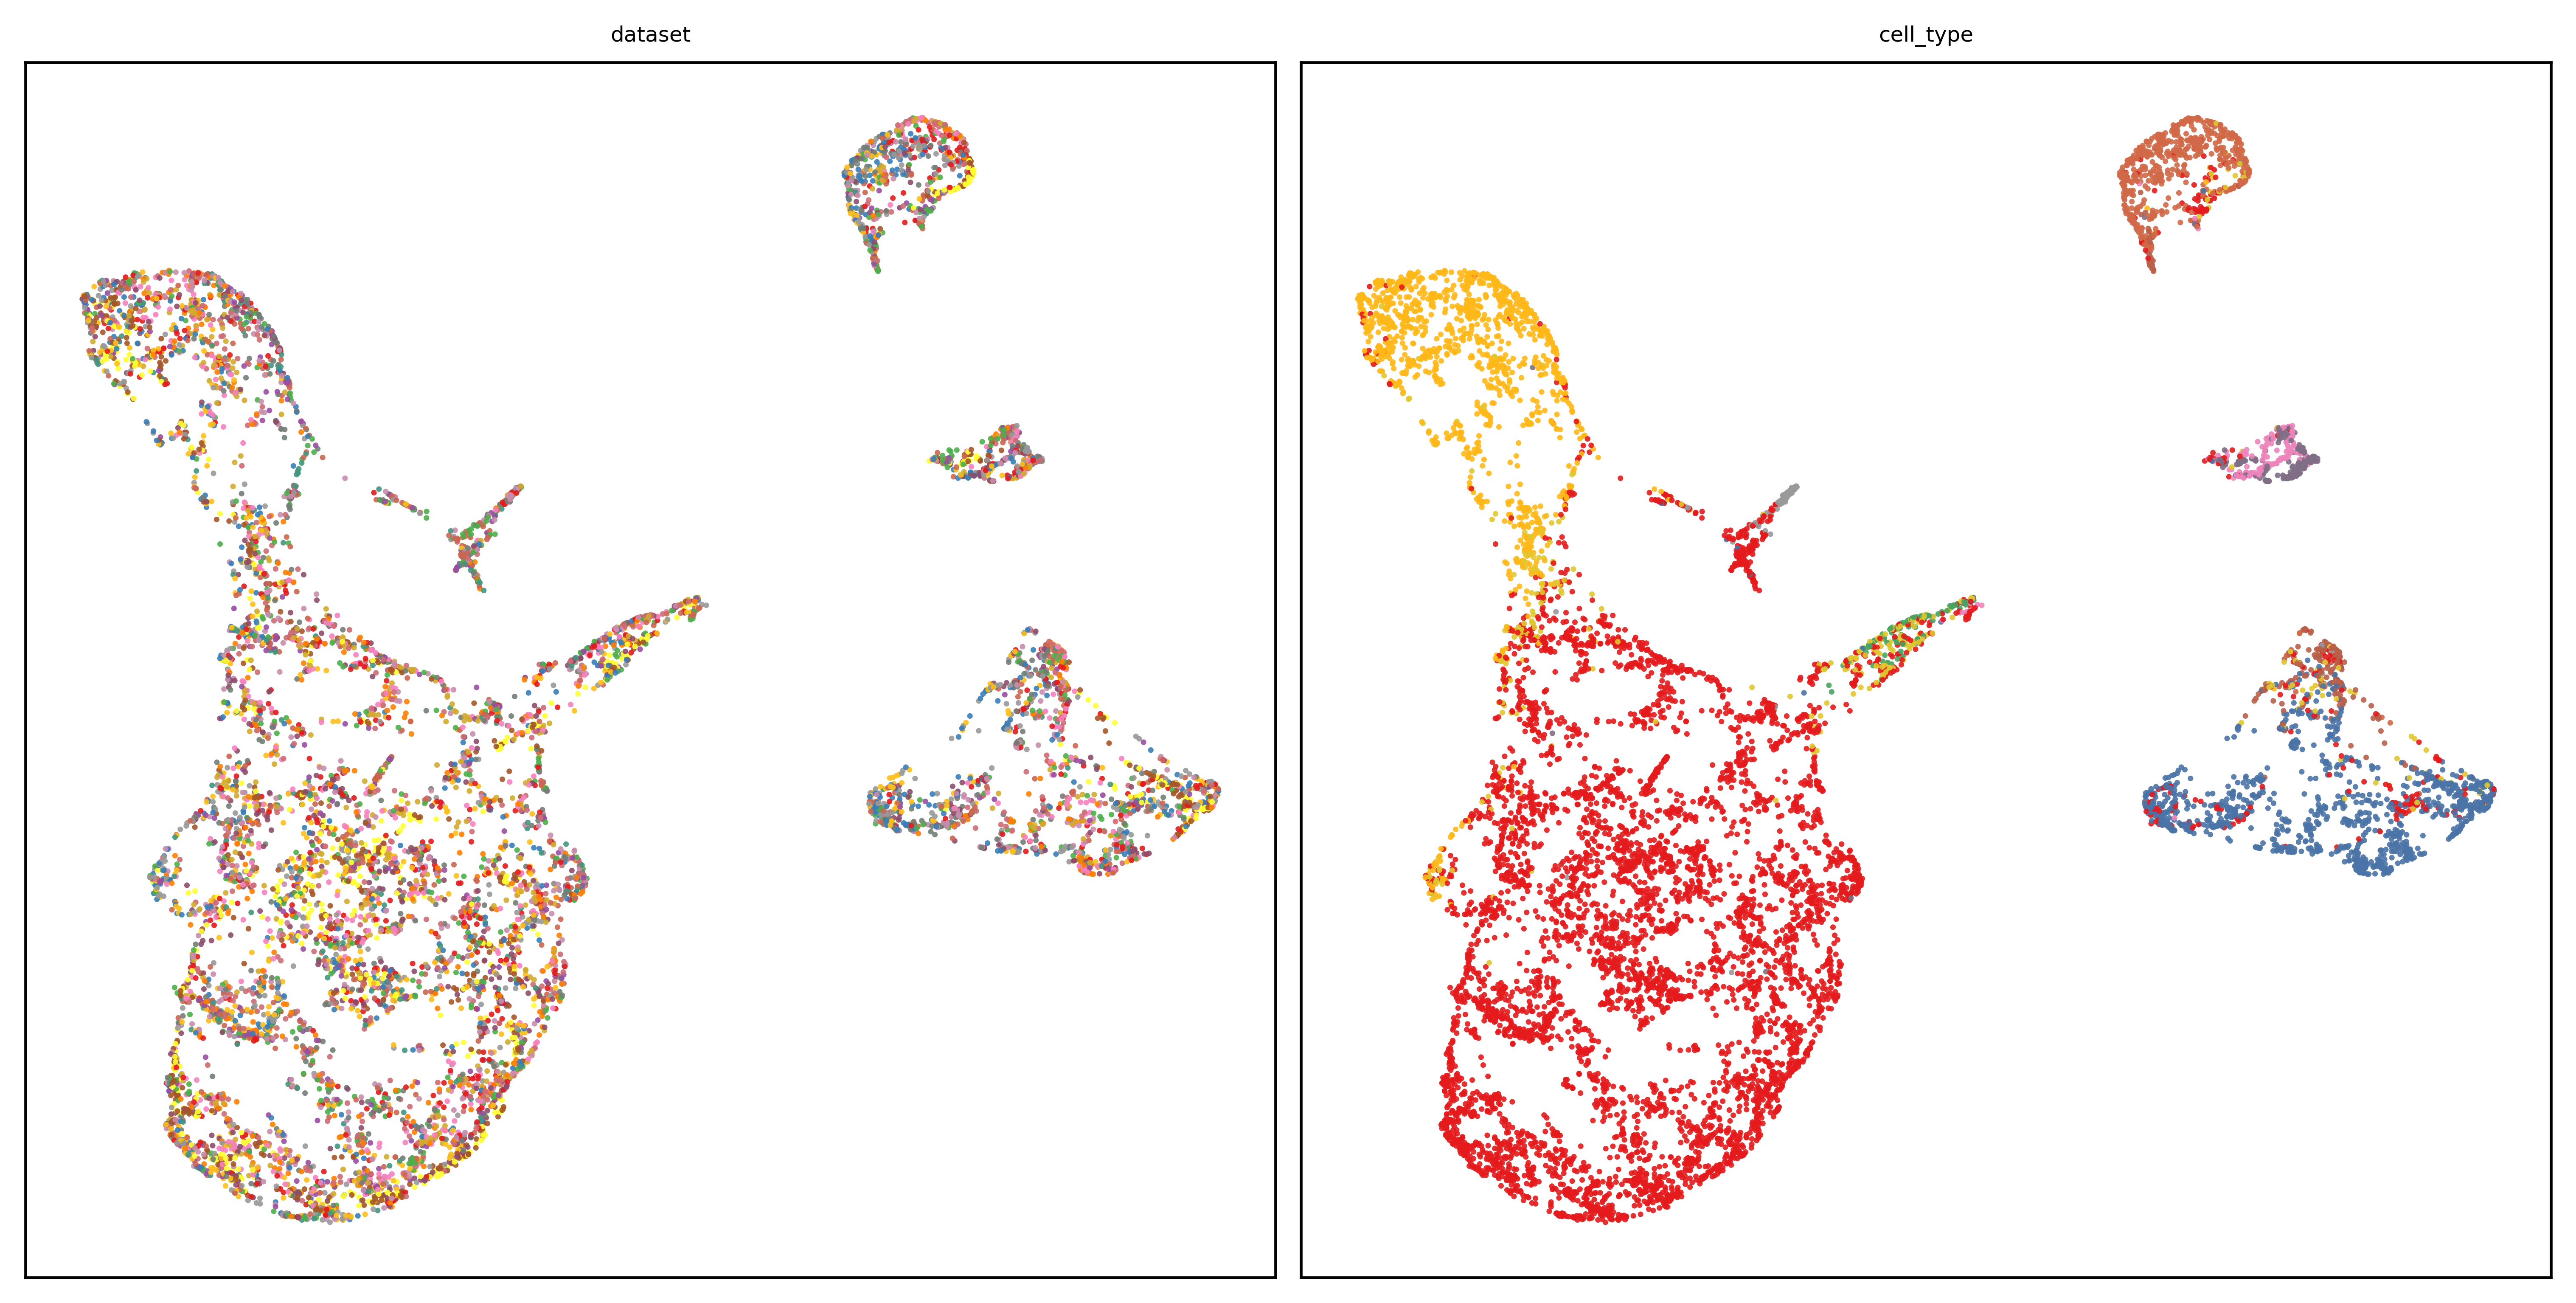

In [28]:
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')

# Plot the UMAP embeddings
color_by = [batch_key, state_key] # Choose which variables you want to visualize
ccd.pl.plot_embedding(
    adata, basis='Concord_UMAP', color_by=color_by, figsize=(10, 5), dpi=600, ncols=2, font_size=6, point_size=10, legend_loc=None,
    save_path=None
)